# Try to predict rho with the smallest turbulence dataset

In [1]:
import numpy as np
import os
import torch
from utils import *
from athena_read import *
from _arfima import arfima

## Read the data with athena_read

In [2]:
data_path='C:/Users/52673/Desktop/NYU MSDS/3-DS-1006 CAPSTONE/data_turb_dedt1_16'

In [4]:
# lets take a look at what a sample looks like
lst = sorted(os.listdir(data_path))[4:]
sample_path = data_path + '/' + lst[4]
sample = athdf(sample_path)
sample['x3v']

array([-0.46875, -0.40625, -0.34375, -0.28125, -0.21875, -0.15625,
       -0.09375, -0.03125,  0.03125,  0.09375,  0.15625,  0.21875,
        0.28125,  0.34375,  0.40625,  0.46875], dtype=float32)

In [5]:
print('size of rho:', np.shape(sample['rho']))

size of rho: (16, 16, 16)


Q: Here the size of the matrix 'rho' for each timestep is (16,16,16). I interprete it like this: When I look into the setting that generate the dataset, I noticed that the mesh-block is set to be 16 for each axis x1, x2 and x3, so it is like cutting a large cube alone with its length, width, and height, each 16 times, and divide it into $16*16*16$ small cubes. So the matrix 'rho' represents the density of each small cube. 

Need to be confirmed.

## Extract rho and time from the original dataset

In [6]:
time = []
rho = []
for name in lst:
    path = data_path+'/'+name
    d = athdf(path)
    time.append(d['Time'])
    rho.append(d['rho'])

rho = np.array(rho)

In [7]:
# check whether the time is evenly distributed
time_gap = []
for i in range(1,len(time)):
    time_gap.append(time[i] - time[i-1])

print('gap between two time steps: ', time_gap)

gap between two time steps:  [0.008732914, 0.004386274, 0.004412315, 0.0044503715, 0.0044987686, 0.004519906, 0.004550522, 0.0045853965, 0.009305038, 0.004717216, 0.0047579333, 0.0048104264, 0.0048691407, 0.0049307495, 0.0049957708, 0.005053267, 0.0051188394, 0.0051931813, 0.0052760392, 0.0053668246, 0.005464494, 0.005568497, 0.0055926517, 0.005605586, 0.005638182, 0.0056675375, 0.0056544095, 0.005655691, 0.0056724995, 0.0057038367, 0.005744025, 0.005776748, 0.005776122, 0.00578624, 0.0058072805, 0.005786702, 0.0057302415, 0.005693823, 0.0056090504, 0.005554706, 0.005525619, 0.0055146664, 0.0055193305, 0.00553903, 0.0055715293, 0.0056138337, 0.0056639016, 0.0057087243, 0.005660951, 0.0056361556, 0.005596459, 0.005533755, 0.0055256784, 0.0055434406, 0.0055660605, 0.005599469, 0.005648643, 0.005661726, 0.00566715, 0.005690187, 0.0057277083, 0.0057603717, 0.005774826, 0.0058030784, 0.0058419406, 0.005887121, 0.005936116, 0.0059885383, 0.0060466826, 0.006113082, 0.0061888993, 0.006265551, 

Q: Here we notice that the time is not evenly distributed, so we might want to encode time into the transformer as well? But how?

## Preprocess on rho

In [8]:
ntime, nx1, nx2, nx3 = np.shape(rho)
ntime, nx1, nx2, nx3

(161, 16, 16, 16)

In [9]:
rho_reshaped = rho.flatten()
np.shape(rho_reshaped)

(659456,)

In [10]:
# check that the reshape does not lose the positional information
time = 131
x1 = 5
x2 = 1
x3 = 3

print(rho[time][x1][x2][x3])
print(rho_reshaped[time*(nx1*nx2*nx3)+x1*(nx2*nx3)+x2*(nx3)+x3])

1.0885758
1.0885758


In [11]:
f = [0+(nx1*nx2*nx3)*i for i in range(10)]
t = [0+(nx1*nx2*nx3)*(i+1) for i in range(10)]
print('the indices for an example pair of feature and target is:')
print('feature: ', f)
print('target: ', t)

the indices for an example pair of feature and target is:
feature:  [0, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768, 36864]
target:  [4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768, 36864, 40960]


In [11]:
def to_windowed(data,meshed_blocks,window_size,pred_size):
    nx1, nx2, nx3 = meshed_blocks
    n = nx1*nx2*nx3
    out = []
    for i in range(len(data)-n*window_size):
        feature  = np.array(data[[i+n*k for k in range(window_size)]])
        target = np.array(data[[i+n*(k+pred_size) for k in range(window_size)]])        
        out.append((feature,target))

    return np.array(out)

# Check the whole pipeline

In [3]:
data, meshed_blocks = get_rho(data_path)

In [4]:
data, meshed_blocks

(array([1.        , 1.        , 1.        , ..., 1.0561857 , 0.9913715 ,
        0.95112133], dtype=float32),
 (16, 16, 16))

In [5]:
pred_size=1
window_size=10
train_proportion = 0.5
val_proportion = 0.375
test_proportion = 0.125

total_len = len(data)
train_len = int(total_len*train_proportion)
val_len = int(total_len*val_proportion)
test_len = int(total_len*test_proportion)

train_data = data[0:train_len]
val_data = data[train_len:(train_len+val_len)]
test_data = data[(train_len+val_len):]

train = to_windowed(train_data,meshed_blocks,window_size,pred_size)
val = to_windowed(val_data,meshed_blocks,window_size,pred_size)
test = to_windowed(test_data,meshed_blocks,window_size,pred_size)

train = torch.from_numpy(train).float()
val = torch.from_numpy(val).float()
test = torch.from_numpy(test).float()

len(train), len(val), len(test)


(288768, 206336, 41472)

In [6]:
seq_pair = to_windowed(data,meshed_blocks,window_size=10,pred_size=1)

In [7]:
seq_pair[60000]

array([[1.0254453, 1.0110215, 0.9992652, 0.9911007, 0.98762  , 0.9890786,
        0.9954866, 1.0079129, 1.0267165, 1.0510368],
       [1.0110215, 0.9992652, 0.9911007, 0.98762  , 0.9890786, 0.9954866,
        1.0079129, 1.0267165, 1.0510368, 1.0802492]], dtype=float32)

In [8]:
train_data,val_data,test_data = train_test_val_split(data , meshed_blocks, train_proportion = 0.5, val_proportion = 0.25, test_proportion = 0.25\
              , window_size = 10, pred_size = 1)

In [9]:
train_data[60000]

tensor([[1.0254, 1.0110, 0.9993, 0.9911, 0.9876, 0.9891, 0.9955, 1.0079, 1.0267,
         1.0510],
        [1.0110, 0.9993, 0.9911, 0.9876, 0.9891, 0.9955, 1.0079, 1.0267, 1.0510,
         1.0802]])

In [10]:
dataset_train, dataset_test, dataset_val = CustomDataset(train_data), CustomDataset(test_data), CustomDataset(val_data)

In [11]:
dataset_train[60000]

(tensor([[1.0254],
         [1.0110],
         [0.9993],
         [0.9911],
         [0.9876],
         [0.9891],
         [0.9955],
         [1.0079],
         [1.0267],
         [1.0510]]),
 tensor([[1.0110],
         [0.9993],
         [0.9911],
         [0.9876],
         [0.9891],
         [0.9955],
         [1.0079],
         [1.0267],
         [1.0510],
         [1.0802]]))

In [12]:
train_val_data = torch.cat((train_data,val_data),0)
dataset_train_val, dataset_test = CustomDataset(train_val_data), CustomDataset(test_data)

In [13]:
dataset_test[60000]

(tensor([[0.9383],
         [0.9157],
         [0.8955],
         [0.8776],
         [0.8615],
         [0.8471],
         [0.8340],
         [0.8221],
         [0.8114],
         [0.8018]]),
 tensor([[0.9157],
         [0.8955],
         [0.8776],
         [0.8615],
         [0.8471],
         [0.8340],
         [0.8221],
         [0.8114],
         [0.8018],
         [0.7937]]))

In [16]:
train_loader, test_loader = get_data_loaders(train_proportion = 0.5, test_proportion = 0.01, val_proportion = 0.49,window_size = 10, \
    pred_size =1, batch_size = 16, num_workers = 1, pin_memory = True, test_mode = True)

In [17]:
d_lst = []
t_lst = []

for data, target in test_loader:
    d_lst.append(data)
    t_lst.append(target)

In [18]:
len(d_lst)

6185

In [19]:
d_lst[0], t_lst[0]

(tensor([[[1.2914],
          [1.2998],
          [1.2999],
          [1.2910],
          [1.2748],
          [1.2538],
          [1.2300],
          [1.2058],
          [1.1827],
          [1.1622]]]),
 tensor([[[1.2998],
          [1.2999],
          [1.2910],
          [1.2748],
          [1.2538],
          [1.2300],
          [1.2058],
          [1.1827],
          [1.1622],
          [1.1508]]]))

In [20]:
targets = t_lst[0]
test_rollout = targets 

In [141]:
enc_in = test_rollout[:,-10:,:]

dec_in = torch.zeros([enc_in.shape[0], 1, enc_in.shape[-1]]).float()
dec_in = torch.cat([enc_in[:,:(10-1),:], dec_in], dim=1).float()

In [22]:
from transformer import Tranformer

model = Tranformer(feature_size=512,num_enc_layers=3,num_dec_layers = 2,\
        d_ff = 512, dropout=0.1,num_head=8)

In [23]:
window_size = 10
device = 'cpu'

test_rollout = torch.Tensor(0)   
test_result = torch.Tensor(0)  
truth = torch.Tensor(0)

for i, (data,targets) in enumerate(test_loader):
    if i == 0:
        enc_in = data
        dec_in = targets
        test_rollout = target
    else:
        enc_in = test_rollout[:,-window_size:,:]
        dec_in = torch.zeros([enc_in.shape[0], 1, enc_in.shape[-1]]).float()
        dec_in = torch.cat([enc_in[:,:(window_size-1),:], dec_in], dim=1).float()
        #dec_in = enc_in[:,:(window_size-1),:]
    enc_in, dec_in, targets = enc_in.to(device), dec_in.to(device), targets.to(device)
    output = model(enc_in, dec_in)

    test_rollout = torch.cat([test_rollout,output[:,-1:,:].detach().cpu()],dim = 1)
    test_result = torch.cat((test_result, output[:,-1,:].view(-1).detach().cpu()), 0)
    truth = torch.cat((truth, targets[:,-1,:].view(-1).detach().cpu()), 0)

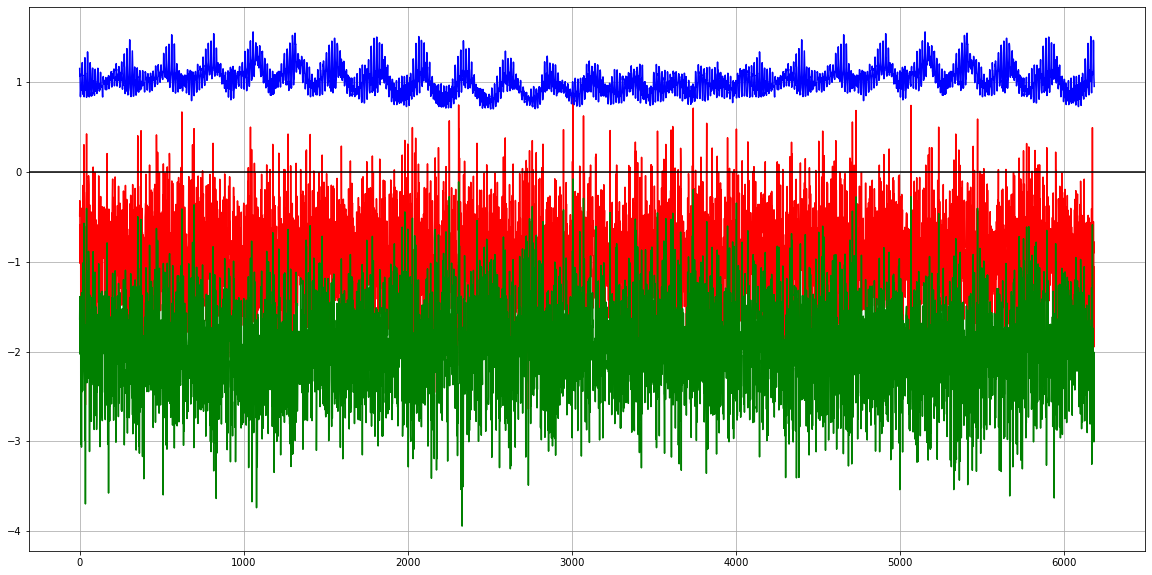

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows =1, ncols=1, figsize=(20,10))
ax.plot(test_result,color="red")
ax.plot(truth,color="blue")
ax.plot(test_result-truth,color="green")
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
plt.show()


All test passed